In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math, os
from itertools import product
from multiprocessing import Pool
from functions import*

import time
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib
import copy
import pdb

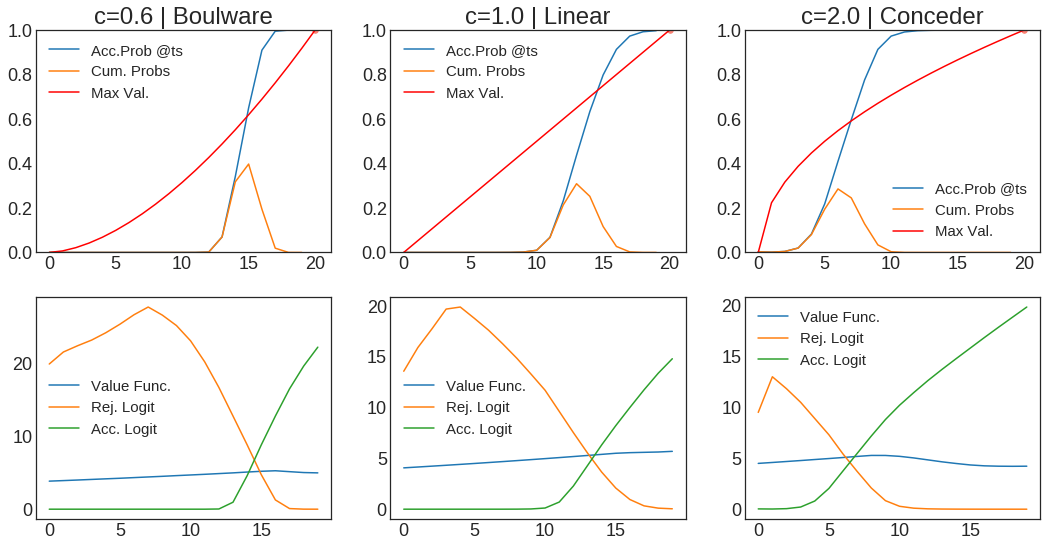

In [68]:
matplotlib.style.use("seaborn-white")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
title_list = ["c=0.6 | Boulware", "c=1.0 | Linear", "c=2.0 | Conceder"]        
plt.figure(figsize=(18,9))

plt_probs_n_optimals(0.6,1,4000,0)
plt_probs_n_optimals(1,1,4000,1)
plt_probs_n_optimals(2.0,1,4000,2)
# plt.savefig("figures/no_discount_accept.png")

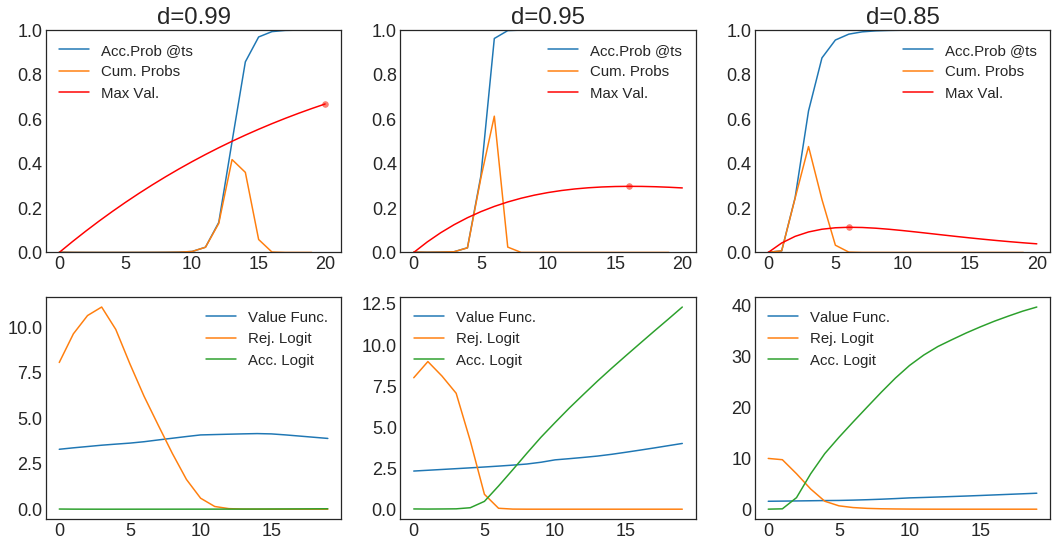

In [63]:
matplotlib.style.use("seaborn-white")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
title_list = ["d=0.99", "d=0.95", "d=0.85"]        
plt.figure(figsize=(18,9))

plt_probs_n_optimals(1.0,0.98,4000,0)
plt_probs_n_optimals(1.0,0.94,4000,1)
plt_probs_n_optimals(1.0,0.85,4000,2)
plt.savefig("figures/discount_accept.png")

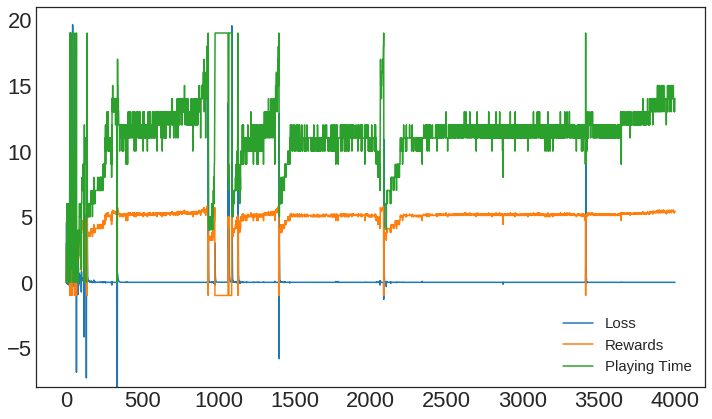

In [67]:
plot_training(1,1)
plt.savefig("figures/training.png")

In [37]:
def plot_training(c,discount):
    path = "c{}-d{}".format(c,discount)
    if not os.path.exists(path + "/figures"):
        os.mkdir(path+ "/figures")
    losses  = np.load(path+"/c{}-d{}-losses.npy".format(c,discount))
    rewards_aggregate = np.load(path+"/c{}-d{}-rewards.npy".format(c,discount))
    times = np.load(path+"/c{}-d{}-times.npy".format(c,discount))
    plt.figure(figsize=(12,7))
    matplotlib.rc('xtick', labelsize=22) 
    matplotlib.rc('ytick', labelsize=22)
    plt.ylim(-8,21)
    plt.plot(losses[:], label="Loss")
    plt.plot(rewards_aggregate, label="Rewards")
    plt.plot(times, label =  "Playing Time")
    plt.legend(fontsize = 15)
    
def plot_agent(c,discount,ep, i):
    path = "c{}-d{}".format(c,discount)
    logit_0 = np.load(path + "/data/{}-logit0.npy".format(ep))
    logit_1 = np.load(path + "/data/{}-logit1.npy".format(ep))
    acceptance_prob = np.load(path + "/data/{}-accept_prob.npy".format(ep))
    binomial_probs  = np.load(path + "/data/{}-binom_prob.npy".format(ep))
    vals_list = np.load(path + "/data/{}-val_function.npy".format(ep))
    
    plt.figure(figsize=(9,12))
    
    plt.subplot(2,1,1)
    plt.plot(acceptance_prob, label = "Acceptance Prob | Timestep")
    plt.plot(binomial_probs, label = "Binomial Probabilities")
    plt.legend(fontsize = 15)
    
    plt.subplot(2,1,2)
    plt.plot(vals_list, label = "Value Function")
    plt.plot(logit_0, label = "Rej. Logit")
    plt.plot(logit_1, label = "Acc. Logit")
    plt.legend(fontsize = 15)
    
def training_ending_stats(c,discount):
    path = "c{}-d{}-play".format(c,discount)
    # if not os.path.exists(path + "/figures"):
    #     os.mkdir(path+ "/figures")
    losses  = np.load(path+"/c{}-d{}-losses.npy".format(c,discount))
    rewards_aggregate = np.load(path+"/c{}-d{}-rewards.npy".format(c,discount))
    times = np.load(path+"/c{}-d{}-times.npy".format(c,discount))
    return losses[-100:], times[-100:], rewards_aggregate[-100:]

def plt_probs_n_optimals(c,discount,ep,j):  
    path = "c{}-d{}".format(c,discount)
    logit_0 = np.load(path + "/data/{}-logit0.npy".format(ep))
    logit_1 = np.load(path + "/data/{}-logit1.npy".format(ep))
    acceptance_prob = np.load(path + "/data/{}-accept_prob.npy".format(ep))
    binomial_probs  = np.load(path + "/data/{}-binom_prob.npy".format(ep))
    vals_list = np.load(path + "/data/{}-val_function.npy".format(ep))
    
    plt.subplot(2,3,j+1)
    plt.plot(acceptance_prob, label = "Acc.Prob @ts")
    plt.plot(binomial_probs, label = "Cum. Probs")
    
    X1, P_res = boulware_actions(c)
    P_res = np_1D(P_res)
    discount_index = np.ones(21)
    for i, __ in enumerate(discount_index):
        if i == 0:
            continue
        else:
            discount_index[i] = discount_index[i-1] * discount
    my_value = discount_index * (6-P_res)/6
    plt.plot(my_value, label = "Max Val.", color = "red")
    plt.scatter(np.argmax(my_value), np.max(my_value), s = 30, c="salmon")
    
    plt.legend(fontsize = 15)
    if i != 0:
        plt.ylabel("")
    plt.title(title_list[j], fontsize = 24)
    plt.ylim(0,1)
    
    plt.subplot(2,3,j+4)
    plt.plot(vals_list, label = "Value Func.")
    plt.plot(logit_0, label = "Rej. Logit")
    plt.plot(logit_1, label = "Acc. Logit")
    plt.legend(fontsize = 15)
    if i != 0:
#         plt.set_yticklabels([])
        plt.ylabel("")
def boulware_actions(c):
    r = 0.0
    T = 20
    V = torch.Tensor([3,2,1])
    c_list = [c]
    X = []
    P_res = []

    for c in c_list:
        a = boulware(V,T,c,r)
        for t in range(T+1):
            state = a.generate_offer(t) # what the agent sees
            uts = a.calc_decision_util(t)
            X.append(state)
            P_res.append(torch.Tensor([uts*6]))

    P_res = torch.stack(P_res)
    # P_res = torch.cat((P_res, P_res, P_res, P_res, P_res))
    X1 = torch.stack(X)
    # X  = torch.cat((X1, X1, X1, X1, X1))
    return X1, P_res

class boulware(object):
    def __init__(self,V,T, c,r):
        self.V = V
        self.T = T
        self.c = c
        self.r = r
    
    def calc_Ft(self,t):
        return (t/self.T)**(1/self.c)

    def calc_decision_util(self,t):
        Ft = self.calc_Ft(t)
        ut = self.r + (1 - self.r)*(1-Ft)
        return ut
    
    def generate_offer(self,t):
        # How to decide which axis to concede.
        ut = self.calc_decision_util(t)
        ut *= torch.sum(self.V)
        
        X = torch.clamp((ut / self.V[0]) + np.random.normal(scale=0.05) ,0,1)
        if X == 1:
            ut -= X*self.V[0]
            Y = torch.clamp((ut / self.V[1])+ np.random.normal(scale=0.05) ,0,1)
            if Y == 1:
                ut -= Y*self.V[1]
                Z = torch.clamp((ut / self.V[2])+ np.random.normal(scale=0.05) ,0,1)
            else:
                Z = 0
        else:
            Y = Z = 0
        
#         print(torch.Tensor([X,Y,Z]))
        return torch.Tensor([X,Y,Z,t])

    def receive(self,offer,t):
        my_offer = 1-offer
        ut = self.calc_decision_util(t)
        ut *= torch.sum(self.V)
        if torch.sum(self.V * my_offer) > ut:
            return torch.Tensor([1])
        else:
            return torch.Tensor([0])
        
def np_1D(X):
    return X.squeeze().detach().numpy()